# 1. Distribución normal multidimensional
Se introduce la distribución normal (o gaussiana) como modelo conjunto para variables continuas. La función de densidad se define en términos de una media (\(m\)) y una matriz de covarianzas (\(S\)).

Se explica su utilidad debido a sus propiedades matemáticas y su aplicabilidad en contextos reales.

# 2. Propiedades de la distribución normal
- **Distribución marginal**: Particionando variables, se derivan distribuciones marginales normales.
- **Distribución condicionada**: También resulta normal y depende de transformaciones lineales. Las transformaciones lineales de distribuciones gaussianas conservan su naturaleza.

# 3. Análisis factorial (FA)
Es una extensión probabilística del Análisis de Componentes Principales (PCA). Busca una representación probabilística de datos visibles (\(v\)) en un espacio de menor dimensión (\(h\)).

El modelo considera un término de ruido gaussiano (\(\epsilon\)) con matriz de covarianzas (\(\Psi\)).

# 4. Modelo gráfico
Se representa cómo las coordenadas latentes (\(h\)) generan datos visibles (\(v\)), formando estructuras en el espacio de datos (como "pancakes").

# 5. Propiedades del FA
El modelo completo combina la distribución latente (\(p(h)\)) y la distribución condicional (\(p(v|h)\)).

Se interpreta como una distribución gaussiana con rango reducido para optimizar el número de parámetros.

# 6. Comparativa: FA y PCA probabilístico
PCA probabilístico (PPCA) es un caso particular del FA con \(\Psi = \sigma^2 I\).

Se presentan diferencias visuales y conceptuales entre ambos métodos usando ejemplos prácticos.

# 7. Mixturas de análisis factorial
Expansión del FA mediante combinaciones de modelos para representar datos más complejos. Se introduce un modelo generativo basado en clusters (\(k\)) que ajusta parámetros mediante el algoritmo EM.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Ejemplo 21.1 (comparativa entre PPCA y FA)

Implementamos una clase para poder aplicar PPCA, para lo que tan solo hay que aplicar las fórmulas que aparecen en la sección 21.4 del libro de Barber. La clase tendrá un método `fit` para entrenar el algoritmo con datos de entrada X, otro método `components` para devolver los componentes encontrados y un método `sample` para generar (inventar) muestras nuevas siguiendo el modelo generativo.

In [ ]:
class PPCA:
    def __init__(self, n_latent):
        self.n_latent = n_latent  # Número de componentes latentes(cuántos componentes principales queremos extraer)
        self.F = None             # Matriz de componentes principales
        self.mu = None            # Media de los datos
        self.sigma_squared = None # Varianza del ruido

    def fit(self, X):
        n_features, n_samples = X.shape

        # Calcular la media y covarianza
        self.mu = np.mean(X, axis=1, keepdims=True)
        X_centered = X - self.mu

        n_samples = X_centered.shape[1]
        S = (X_centered @ X_centered.T) / n_samples

        # Autovalores y autovectores de S (np.linalg.eigh(S))
        eigenvalues, eigenvectors = np.linalg.eigh(S)

        # Ordenar los autovalores en orden descendente.
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Me quedo con los n_latent primeros
        eigenvectors = eigenvectors[:, :self.n_latent]

        # Calcular el valor de sigma óptimo
        self.sigma_squared = np.sum(eigenvalues[self.n_latent:]) / (n_features - self.n_latent)

        # Calcular F
        I = np.eye(self.n_latent)
        self.F = eigenvectors @ np.diag(np.sqrt(eigenvalues[:self.n_latent] - self.sigma_squared))

    def sample(self, n_samples=1):
        """
        Generar muestras a partir del modelo PPCA entrenado.

        Entrada:
        n_samples (int): Número de muestras a generar

        Salida:
        Muestras generadas con shape (n_features, n_samples)
        """
        rng = np.random.default_rng()

        # Muestrear del espacio reducido.
        h = rng.standard_normal((self.n_latent, n_samples))

        # Crear una media de ceros de tamaño n_features y  covarianza diagonal con sigma_squared
        mean = np.zeros(self.F.shape[0])
        covariance = self.sigma_squared * np.eye(self.F.shape[0])

        # Generar el ruido multivariante para n_samples
        noise = rng.multivariate_normal(mean, covariance, n_samples).T  # Transpuesta para tener forma (n_features, n_samples)

        # Generar muestras.
        X_sampled = self.F @ h + noise + self.mu

        return X_sampled

    def components(self):
        return self.F

Cargamos el conjunto de datos MNIST...

In [ ]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, cache=True)

... y nos quedamos con 100 sietes.

In [ ]:
idx_sevens = (np.where(y=='7')[0])[:100]
digit7 = X[idx_sevens,:].T

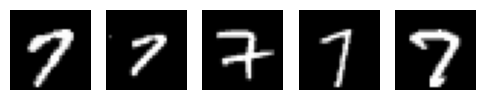

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(6,3))
for i in range(5):
    axs[i].set_axis_off()
    axs[i].imshow(digit7[:,i].reshape((28,28)), cmap='gray')

### Aplicamos PPCA, con 5 componentes ocultas.

In [ ]:
ppca = PPCA(n_latent=5)
ppca.fit(digit7)

In [ ]:
components = ppca.components()

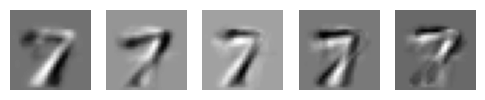

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(6,3))
for i in range(5):
    axs[i].set_axis_off()
    axs[i].imshow(components[:,i].reshape((28,28)), cmap='gray')

Extraemos 25 muestras del modelo. Observamos que hay ruido por toda la imagen.

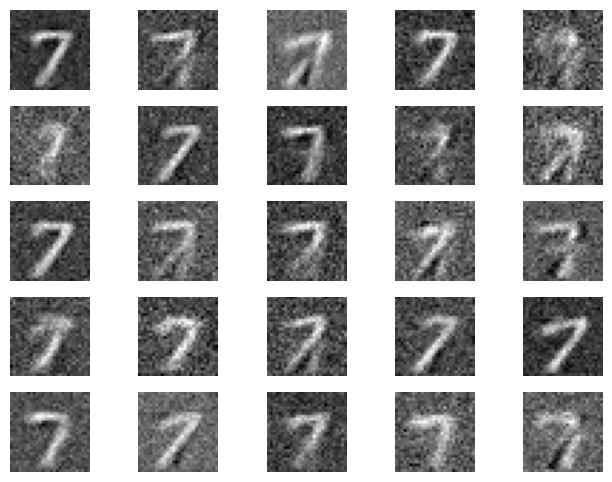

In [ ]:
samples = ppca.sample(25)

fig, axs = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        axs[i,j].set_axis_off()
        axs[i,j].imshow(samples[:,i*5+j].reshape((28,28)), cmap='gray')

### Aplicamos FA.

En este caso, podemos utililizar la implementación en Scikit-Learn.

Como habitualmente, hay que tener cuidado con la representación de los datos. Nuestra representación asume que las columnas de X corresponden a puntos distintos y las filas son las características mientras que en Scikit-Learn es al revés.

In [ ]:
from sklearn.decomposition import FactorAnalysis

In [ ]:
fa = FactorAnalysis(n_components=5, random_state=0)
fa.fit(digit7.T)

FactorAnalysis(n_components=5)

In [ ]:
components_fa = fa.components_

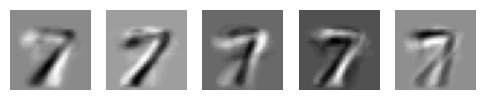

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(6,3))
for i in range(5):
    axs[i].set_axis_off()
    axs[i].imshow(components_fa[i].reshape((28,28)), cmap='gray')

Como en la clase PPCA, necesitamos una función que nos permita muestrear utilizando el modelo generativo. Como Scikit-Learn no la proporciona, la implementamos nosotros.

In [ ]:
def sampleFA(fa, n_samples=1):
    rng = np.random.default_rng()

    # Dimensiones
    n_latent = fa.n_components
    n_features = fa.components_.shape[1]

    # Muestrear del espacio reducido Z ~ N(0, I)
    h = rng.standard_normal((n_latent, n_samples))

    # Transponer componentes latentes (F)
    F = fa.components_.T

    # Crear una matriz de covarianza diagonal para el ruido
    covariance = np.diag(fa.noise_variance_)
    # Generar ruido multivariante
    noise = rng.multivariate_normal(np.zeros(n_features), covariance, n_samples).T

    mu = fa.mean_

    # Generar muestras utilizando el modelo generativo
    X_sampled = F @ h + noise + mu[:, np.newaxis]

    return X_sampled


Extraemos 25 muestras del modelo. A diferencia de lo que ocurría con PPCA, en aquellas regiones donde la varianza de las muestras es 0 obtenemos representaciones nítidas.

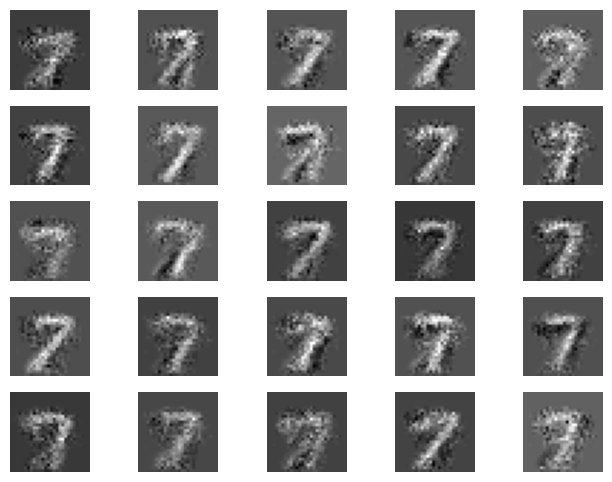

In [ ]:
samples_fa = sampleFA(fa, 25)

fig, axs = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        axs[i,j].set_axis_off()
        axs[i,j].imshow(samples_fa[:,i*5+j].reshape((28,28)), cmap='gray')

### Cuestiones
¿Qué relación guarda el efecto anterior con el hecho de que la varianza del ruido tiene ahora diferentes valores en la diagonal?

#### Efecto de la varianza del ruido en FA

En Factor Analysis (FA), la varianza del ruido (`noise_variance_`) indica la incertidumbre asociada a cada característica:

- **Confianza por característica**: Características con menor varianza son más confiables y están mejor representadas en el modelo; aquellas con mayor varianza están más afectadas por el ruido.
- **Generación de datos**: Características con mayor varianza producen muestras más dispersas, mientras que características con menor varianza generan valores más consistentes.
- **Reconstrucción de datos**: Dimensiones con alta varianza de ruido son menos precisas, lo que genera reconstrucciones más borrosas.


In [ ]:
nv =fa.noise_variance_.reshape(28,28)

#### Visualización de la varianza del ruido

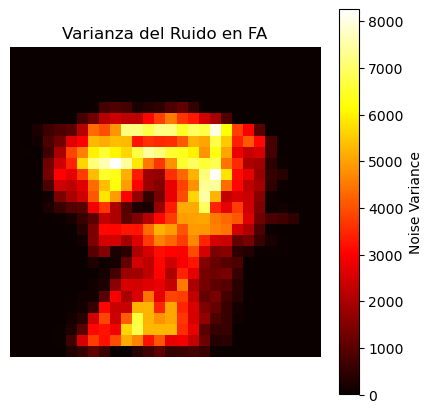

In [ ]:
# Visualización
plt.figure(figsize=(5, 5))
plt.imshow(nv, cmap='hot', interpolation='nearest')
plt.colorbar(label='Noise Variance')
plt.title('Varianza del Ruido en FA')
plt.axis('off')
plt.show()

#### Interpretación de la visualización

Al visualizar la varianza del ruido como una imagen:

- **Áreas con varianza alta** (colores brillantes): Representan características afectadas por mayor incertidumbre; contribuyen menos al modelo.
- **Áreas con varianza baja** (colores oscuros): Son más consistentes y están mejor relacionadas con las componentes latentes.

Esto afecta la calidad de las reconstrucciones y la dispersión en las muestras generadas, especialmente en las áreas con mayor ruido.

¿Qué valores esperarías encontrar en qué posiciones? ¿En la primera fila? ¿En la última? Realiza un breve análisis de los resultados.

#### Análisis de la varianza del ruido en las filas

1. **Primera fila (píxeles superiores)**:
   - Es probable que los valores de varianza del ruido en la **primera fila** (los píxeles más cercanos a la parte superior de la imagen de un dígito) sean relativamente bajos. Esto se debe a que, en dígitos como el "7", los píxeles superiores contienen información estructural clave (como el trazo superior del número) que el modelo de FA suele representar de manera más precisa.
   - **Expectativa**: Varianza baja, es decir, ruido pequeño.

2. **Última fila (píxeles inferiores)**:
   - En la **última fila** (píxeles cercanos a la base), es posible que los valores de varianza del ruido sean más altos, ya que en muchos dígitos de MNIST, la parte inferior tiene menos información estructural distintiva o es más propensa a variabilidad. Esto podría indicar que el modelo tiene menos confianza en las características en estas áreas, ya que hay más "ruido" o menos patrones repetitivos.
   - **Expectativa**: Varianza alta, es decir, ruido más grande.

#### Breve análisis de los resultados:
- Si se observa que los píxeles de la parte superior tienen una varianza baja y los de la parte inferior una varianza alta, esto indica que el modelo de FA está capturando bien las características estructurales importantes del dígito en las zonas superiores (como los trazos del "7"), pero tiene más dificultad para modelar la parte inferior, lo cual es típico en muchos números escritos a mano.
